# Analysis of GP Oral Nutritional Supplements (ONS) data

This notebook has been developed to better understand Oral Nutritional Supplement data to help guide development of a measure to calculate percentage prescribing of powder as a proportion of all ONS..
. 

I will attempt to analyse this by looking at the formulation descriptions. I will also look at quantity unit measures to compare what this captures. 
#### **What the steps are:**

Below is a subsection of the Entity Relationship Diagram (ERD) illustrating how the key tables link together:

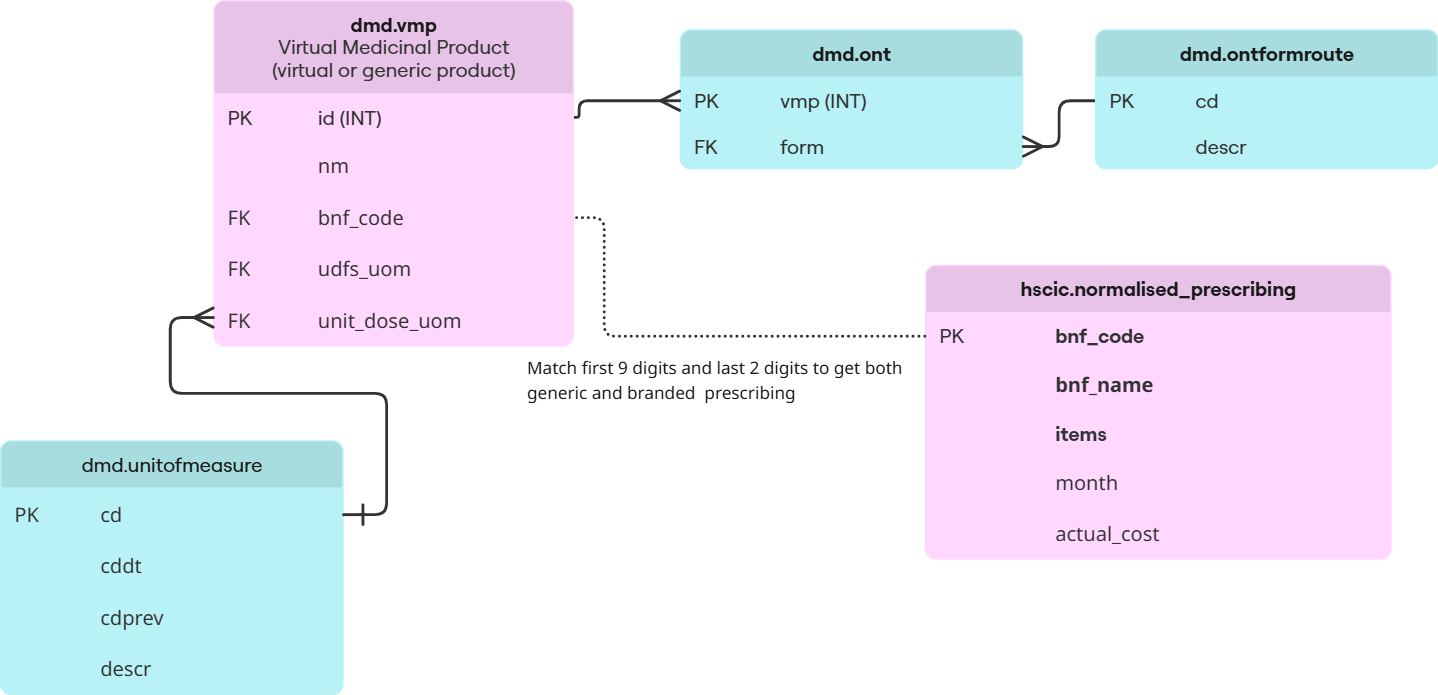

**Entity Relationship Diagram (ERD) Explanation:**

The diagram shows the tables from the Dictionary of Medicines and Devices (dm+d) dataset used in this analysis. The dm+d is the NHS national standard database for medicines and medical devices, containing comprehensive details about drugs, including codes, names, and mappings. The dataset is made available by the NHS Business Services Authority (NHSBSA) through the [NHS TRUD](onenote:#Chris%20notebook&section-id={3C5B1879-80B3-45D1-A622-F09202323047}&page-id={0A97DF0F-8AE6-4652-9AB3-AA333872F0FE}&object-id={815FC114-B71A-0840-2737-61A2662D26CC}&A4&base-path=https://unioxfordnexus-my.sharepoint.com/personal/prhc1002_ox_ac_uk/Documents/Caroline%20@%20Nexus365/Prescribing%20database.one) (Technology Reference Update Distribution) portal.

**Key Tables in the ERD:**

-   **`dmd.vmp`**: Contains each inhaler's unique VMP identifier (`id`), its name (`nm`), BNF code (`bnf_code`) and additional metadata.

-   **`dmd.ont`**:** Links each VMP (`vmp`) to a specific form code (`form`). This code connects to `dmd.ontformroute`, providing a descriptive form.

-   **`dmd.vmpp`**: Matches a VMP code (`vmp_code`) with its associated product packs. Allows us to obtain unit of measure.
-   
-   **`dmd.unitofmeasure`**: Matches a unit of measure code (`udfs_uom`) with its associated description

-   **`hscic.normalised_prescribing`**: Records prescribing activity data, including BNF code, number of items prescribed, quantity, and prescribing month.

Suggested wording for why it matters (from Nuala Hampson, CSH Associate and Pharmacy Lead, The Centre for Sustainable Healthcare

"Excess or unnecessary prescribing of oral nutritional products represents both a financial and environmental cost. Liquid ONS have a short shelf life after opening and are often disposed of down sinks, risking eutrophication of water sources (increased nutrient levels in aquatic ecosystems, leading to algal blooms, oxygen-depleted “dead zones” and water quality degradation). ONS packaging is often multi-component (bottles, lids, labels) and comprised of multiple plastics. Recycling may be technically possible but unavailable locally. Specific manufacturer guidance on how to safely dispose of unused product and packaging, and research into the effects of disposal of product and packaging, is lacking.  

NHS London Procurement Partnership. 2025. Scoping the sustainability impact of Oral Nutritional Supplements. Integrating sustainability with procurement and Prescribing. Available at  https://www.lpp.nhs.uk/news/read-our-report-on-exploring-the-sustainability-impact-of-oral-nutritional-supplements-ons/
In this they have done a carbon modelling of liquid ONS versus powdered ONS plus milk. There is a lack of data but the potential benefit of powdered products are:
less bulky, lower weight, leading to lower transport emissions. 
potentially easier to dispose of and less likely to be poured down sinks
risk of waste is potentially lower as they will be made up according to need. "


Setting Up Our Tools
--------------------


In [1]:
# Import the libraries we need:
from ebmdatalab import bq                  # Connects us to the prescribing database
import pandas as pd                        # Our main tool for handling data tables
import matplotlib.pyplot as plt            # Creates charts and graphs
import numpy as np                         # Helps with numerical calculations
import os                                  # Manages file paths
from datetime import datetime              # For date handling
import seaborn as sns                      # For enhanced visualisations

# This setting ensures we can see full product names in our results
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

# Create data directory if it doesn't exist
os.makedirs('../ONS_data', exist_ok=True)

Extracting ONS Prescribing Data
---------------------------------------------------

We now extract all ONS prescribing data from the past 5 years with formulation information.


In [2]:
sql_ons_prescribing = """
WITH ons_supplements AS (
  SELECT 
    rx.bnf_code,
    rx.bnf_name,
    rx.month,
    rx.practice,
    SUM(rx.items) AS items,
    SUM(rx.actual_cost) AS actual_cost
  FROM hscic.normalised_prescribing rx
  WHERE rx.bnf_code LIKE '091301%'
    AND EXTRACT(YEAR FROM month) = 2025
  GROUP BY rx.bnf_code, rx.bnf_name, rx.month, rx.practice
)
SELECT 
  ons.bnf_code,
  ons.bnf_name,
  SUM(ons.items) AS items,
  SUM(ons.actual_cost) AS actual_cost,
  CASE 
    WHEN ont_route.descr IS NULL THEN 'Formulation not specified'
    ELSE ont_route.descr
  END AS formulation_descr
FROM ons_supplements ons
LEFT JOIN dmd.vmp vmp 
  ON CONCAT(SUBSTR(ons.bnf_code,0,9),SUBSTR(ons.bnf_code,-2)) = 
     CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
LEFT JOIN dmd.ont ont 
  ON vmp.id = ont.vmp
LEFT JOIN dmd.ontformroute ont_route 
  ON ont.form = ont_route.cd
GROUP BY ons.bnf_code, ons.bnf_name, ont_route.descr
ORDER BY SUM(ons.actual_cost) DESC
"""

# Execute query and cache results
df_ons_prescribing = bq.cached_read(
    sql_ons_prescribing,
    csv_path=os.path.join('..', 'ONS_data', 'ONS_prescribing_detailed.csv')
)

**This query will process 196.64 GB when run..**

In [3]:
print(f"Data shape: {df_ons_prescribing.shape}")
print(f"Number of unique drugs: {df_ons_prescribing['bnf_name'].nunique()}")
# Display sample of the data
display(df_ons_prescribing.head(10))

Data shape: (257, 5)
Number of unique drugs: 234


,bnf_code,bnf_name,items,actual_cost,formulation_descr
0,0913011W0BBABAB,Fortisip Compact Protein liquid (9 flavours),263892,2.421644e+07,liquidfood.oral
1,0913011V0BCAAAC,Ensure Compact liquid (4 flavours),213559,1.539387e+07,liquidfood.gastroenteral
2,0913011V0BCAAAC,Ensure Compact liquid (4 flavours),213559,1.539387e+07,liquidfood.oral
3,0913011V0BDAAAD,Fortisip Compact liquid (8 flavours),258630,1.524359e+07,liquidfood.oral
4,0913011N0BEAAAA,Ensure Plus milkshake style liquid (9 flavours),249111,1.070076e+07,liquidfood.gastroenteral
5,0913011N0BEAAAA,Ensure Plus milkshake style liquid (9 flavours),249111,1.070076e+07,liquidfood.oral
6,0913011N0BFAAAG,Fortisip Bottle (5 flavours),206034,9.416012e+06,liquidfood.oral
7,0913011S0BDAAAC,Ensure TwoCal liquid (4 flavours),32800,5.631091e+06,liquidfood.gastroenteral
8,0913011S0BDAAAC,Ensure TwoCal liquid (4 flavours),32800,5.631091e+06,liquidfood.oral
9,0913011M0BEABAA,Fortijuce liquid (5 flavours),99160,5.367341e+06,liquidfood.oral


We  can now review the unique formulations:

In [4]:
# List unique formulation descriptions
unique_formulations = df_ons_prescribing['formulation_descr'].dropna().unique()

# Display them in a sorted list
sorted(unique_formulations)


['Formulation not specified',
 'grocerysemisolid.oral',
 'liquid.oral',
 'liquidfood.gastroenteral',
 'liquidfood.oral',
 'powderfoodmix.oral']

Review a sample from each category
-----------------------------------------------

View a sample of products to understand how they are classified

In [5]:
sampled = (
    df_ons_prescribing
    .groupby('formulation_descr', group_keys=False)
    .apply(lambda g: g[['bnf_code', 'bnf_name', 'formulation_descr']]
           .drop_duplicates()
           .sample(n=min(10, len(g.drop_duplicates())), replace=False))
    .reset_index(drop=True)
)

sampled


/tmp/ipykernel_48/1055162686.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[['bnf_code', 'bnf_name', 'formulation_descr']]


,bnf_code,bnf_name,formulation_descr
0,0913011W0BBAAAA,Fortisip Compact Protein Starter Pack liquid,Formulation not specified
1,0913011C0BCAFAE,Complan Shake Starter Pack sachets,Formulation not specified
2,0913011E0BFAEAG,Foodlink Extra Starter Pack sachets,Formulation not specified
3,0913011A0BBADAB,Aymes ActaSolve Savoury Starter Pack powder,Formulation not specified
4,0913011M0BBAAAH,Aymes Actagain Juce Starter Pack liquid,Formulation not specified
5,0913011X0BCAAAC,Altraplen Compact Daily Starter Pack liquid,Formulation not specified
6,0913011B0BCAAAC,Foodlink Smoothie Starter Pack sachets,Formulation not specified
7,0913011N0BBAAAK,Altraplen Energy Starter Pack liquid,Formulation not specified
8,0913011C0BFAGAF,Foodlink Complete Starter Pack powder,Formulation not specified
9,0913011S0BBACAG,Aymes 2.0kcal Starter Pack liquid,Formulation not specified


Examining the sample products, it appears that powder based products might be identified with the formulation "powderfoodmix.oral" . However, **a concern is the category "Formulation not specified", which requires further analysis as it may also contain powders.**

Let's find out how many unique products have the description "Formulation not specified"


In [6]:
# Filter rows with missing formulation info
unspecified = df_ons_prescribing[df_ons_prescribing['formulation_descr'] == 'Formulation not specified']

# Count unique products
count_unique = unspecified[['bnf_code', 'bnf_name']].drop_duplicates().shape[0]
count_unique


36

This is only 36 unique products. Let's review the products in this category to identify if any powders are included

In [7]:
unique_products = unspecified[['bnf_code', 'bnf_name']].drop_duplicates()
unique_products

unique_products.sort_values(['bnf_name'])

,bnf_code,bnf_name
129,0913011M0BCAAAF,Altrajuce Starter Pack liquid
143,0913011X0BCAAAC,Altraplen Compact Daily Starter Pack liquid
125,0913011V0BBAEAB,Altraplen Compact Starter Pack liquid
132,0913011N0BBAAAK,Altraplen Energy Starter Pack liquid
184,0913011K0BBACAC,Altraplen Protein Starter Pack liquid
186,0913011S0BBACAG,Aymes 2.0kcal Starter Pack liquid
209,0913011J0BBABAH,Aymes ActaCal Creme Starter Pack dessert
223,0913011G0BBAAAA,Aymes ActaSolve Delight Starter Pack powder
234,0913011E0BBAEAE,Aymes ActaSolve High Energy Starter Pack powder
219,0913011H0BBAAAA,Aymes ActaSolve Protein Compact Starter Pack powder


We find there are a signficiant number of powders listed. To capture products in this category, we could select those with the term 'powder' in the name eg Aymes Shake Compact Starter Pack powder

This raises the question whether it would be sufficient to search for products with "powder" in the BNF name to identify all powder products regardless of their formulation description. To explore if this theory could be correct, we will review a list of the products classified as powderfoodmix.oral to see if powder is listed in the name.


Let's first create a data frame for all products in the powderfoodmix.oral category and examine the BNF names to identify whethery they have "powder" mentioned in their BNF namees.

In [8]:
# Filter for powder formulations
df_powder = df_ons_prescribing[
    df_ons_prescribing['formulation_descr'] == 'powderfoodmix.oral'
].copy()

# Drop duplicates so each product only appears once (optional)
df_powder = df_powder[['bnf_code', 'bnf_name', 'formulation_descr']].drop_duplicates()

# Save to CSV in the folder one level up in a folder called 'data'
output_path = os.path.join('..', 'ONS_data', 'powderfoodmix_products.csv')
df_powder.to_csv(output_path, index=False)

output_path

#view a sample
display (df_powder.head(20))

,bnf_code,bnf_name,formulation_descr
51,0913011E0BEAAAD,Scandishake Mix oral powder 85g sachets banana,powderfoodmix.oral
60,0913011E0BEADAD,Scandishake Mix oral powder 85g sachets strawberry,powderfoodmix.oral
62,0913011E0BEACAD,Scandishake Mix oral powder 85g sachets chocolate,powderfoodmix.oral
72,0913011E0BEAFAD,Scandishake Mix oral powder 85g sachets vanilla,powderfoodmix.oral
108,0913011E0BEAEAD,Scandishake Mix oral powder 85g sachets unflavoured,powderfoodmix.oral
120,0913011E0BEABAD,Scandishake Mix oral powder 85g sachets caramel,powderfoodmix.oral


Examining this list shows they all contain the word "powder" in their BNF name.

However,there are only 6 products in this category. From my domain knowledge as a pharmacist, I know this is very far from a comprehensive list. It is missing some well known powder products such as Complan powder. 

**The formulation description "powderfoodmix.oral" is unsuitable for this measure as it identifies an insufficient number of powder supplemeents**

Let's see what we get, when we filter for products with the term 'powder' in the bnf name.

In [9]:
# Filter for BNF names containing the word 'powder' (case-insensitive)
df_powder_name = (
    df_ons_prescribing[
        df_ons_prescribing['bnf_name'].str.contains('powder', case=False, na=False)
    ]
    .copy()
)

# Keep only unique products
df_powder_name = df_powder_name[['bnf_code', 'bnf_name', 'formulation_descr']].drop_duplicates()


# Save to Excel in the folder one level up called 'data'
output_path = os.path.join('..', 'ONS_data', 'bnf_name_contains_powder.csv')
df_powder_name.to_csv(output_path, index=False)

print(f"Data shape: {df_powder_name.shape}")

print(f"Number of unique drugs: {df_powder_name['bnf_name'].nunique()}")
display (df_powder_name.head(20))

Data shape: (114, 3)
Number of unique drugs: 108


,bnf_code,bnf_name,formulation_descr
28,0913011C0BBAAAH,Aymes Shake powder 57g sachets banana,liquidfood.oral
36,0913011C0BBAFAH,Aymes Shake powder 57g sachets strawberry,liquidfood.oral
44,0913011C0BBAGAH,Aymes Shake powder 57g sachets vanilla,liquidfood.oral
45,0913011F0BBAAAA,Aymes Shake Compact powder 57g sachets banana,liquidfood.oral
50,0913011E0BEAAAD,Scandishake Mix oral powder 85g sachets banana,liquidfood.oral
51,0913011E0BEAAAD,Scandishake Mix oral powder 85g sachets banana,powderfoodmix.oral
54,0913011C0BBACAH,Aymes Shake powder 57g sachets chocolate,liquidfood.oral
56,0913011B0BBAAAA,Aymes ActaSolve Smoothie powder 66g sachets mango,liquidfood.oral
57,0913011C0BFAAAC,Foodlink Complete powder 57g sachets banana,liquidfood.oral
59,0913011E0BEADAD,Scandishake Mix oral powder 85g sachets strawberry,liquidfood.oral


Let's find out what formulation descrptiions are attached to this

In [10]:
# Identify unique formulation descriptions in the filtered dataframe
unique_formulations_powder = (
    df_powder_name['formulation_descr']
    .dropna()
    .unique()
)

unique_formulations_powder


array(['liquidfood.oral', 'powderfoodmix.oral',
       'Formulation not specified'], dtype=object)

We see that these products with powder in their bnf names can be found in 3 categoreis: 'liquidfood.oral', 'powderfoodmix.oral',
       'Formulation not specified'. 
This confirms that formulation_descr alone isn't an appropriate way to capture all powders.

The next theory worth exploring is whether measurement units can help identify whether a product is a powder. For this, we run a new sql query.

In [11]:
sql_ons_prescribing_with_units = """
WITH ons_supplements AS (
  SELECT 
    rx.bnf_code,
    rx.bnf_name,
    rx.month,
    rx.practice,
    SUM(rx.items) AS items,
    SUM(rx.actual_cost) AS actual_cost
  FROM hscic.normalised_prescribing rx
  WHERE rx.bnf_code LIKE '091301%'
    AND EXTRACT(YEAR FROM month) = 2025
  GROUP BY rx.bnf_code, rx.bnf_name, rx.month, rx.practice
)
SELECT 
  ons.bnf_code,
  ons.bnf_name,
  SUM(ons.items) AS items,
  SUM(ons.actual_cost) AS actual_cost,
  CASE 
    WHEN uom.descr IS NULL THEN 'Unit not specified'
    ELSE uom.descr
  END AS unit_of_measure
FROM ons_supplements ons
LEFT JOIN dmd.vmpp vmpp 
  ON CONCAT(SUBSTR(ons.bnf_code,0,9),SUBSTR(ons.bnf_code,-2)) = 
     CONCAT(SUBSTR(vmpp.bnf_code,0,9),SUBSTR(vmpp.bnf_code,-2))
LEFT JOIN dmd.unitofmeasure uom 
  ON vmpp.qty_uom = uom.cd
GROUP BY ons.bnf_code, ons.bnf_name, uom.descr
ORDER BY SUM(ons.actual_cost) DESC
"""

# Execute query and cache results
df_ons_prescribing_with_units = bq.cached_read(
    sql_ons_prescribing_with_units,
    csv_path=os.path.join('..', 'ONS_data', 'ONS_prescribing_with_units.csv')
)

This query will process 197.39 GB when run.

In [12]:
print(f"Data shape: {df_ons_prescribing_with_units.shape}")
print(f"Number of unique drugs: {df_ons_prescribing_with_units['bnf_name'].nunique()}")
# Display sample of the data
display(df_ons_prescribing_with_units.head(10))

Data shape: (256, 5)
Number of unique drugs: 236


,bnf_code,bnf_name,items,actual_cost,unit_of_measure
0,0913011N0BEAAAA,Ensure Plus milkshake style liquid (9 flavours),2241999,9.630682e+07,ml
1,0913011W0BBABAB,Fortisip Compact Protein liquid (9 flavours),597020,5.479702e+07,ml
2,0913011V0BCAAAC,Ensure Compact liquid (4 flavours),481278,3.472049e+07,ml
3,0913011V0BDAAAD,Fortisip Compact liquid (8 flavours),583984,3.437581e+07,ml
4,0913011N0BFAAAG,Fortisip Bottle (5 flavours),465156,2.126397e+07,ml
5,0913011M0BDAAAB,Ensure Plus Juce liquid (6 flavours),242812,1.939837e+07,ml
6,0913011N0BEAAAA,Ensure Plus milkshake style liquid (8 flavours),287631,1.222646e+07,ml
7,0913011M0BEABAA,Fortijuce liquid (5 flavours),224000,1.215130e+07,ml
8,0913011L0BBAAAB,Ensure Plus Fibre liquid (5 flavours),51024,6.938965e+06,ml
9,0913011S0BDAAAC,Ensure TwoCal liquid (4 flavours),36968,6.335113e+06,ml


We  can now review the unique units of measure:

In [13]:
unique_uom = df_ons_prescribing_with_units['unit_of_measure'].dropna().unique()

print(unique_uom)

['ml' 'gram' 'sachet']


Let's examine a sample of products for each unit

In [14]:
sampled_units = (
    df_ons_prescribing_with_units
    .groupby('unit_of_measure', group_keys=False)
    .apply(lambda g: g[['bnf_code', 'bnf_name', 'unit_of_measure']]
           .drop_duplicates()
           .sample(n=min(10, len(g.drop_duplicates())), replace=False))
    .reset_index(drop=True)
)

sampled_units

/tmp/ipykernel_48/3467793306.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[['bnf_code', 'bnf_name', 'unit_of_measure']]


,bnf_code,bnf_name,unit_of_measure
0,0913011C0BBACAH,Aymes Shake powder 57g sachets chocolate,gram
1,0913011J0BBAAAF,Aymes ActaCal Creme dessert (2 flavours),gram
2,0913011C0BFAHAK,Foodlink Aqua powder (4 flavours),gram
3,0913011J0BFAAAB,Fresubin 2kcal Creme dessert cappuccino,gram
4,0913011C0BBAIAH,Aymes Shake powder (5 flavours),gram
5,0913011J0BEABAA,Forticreme Complete dessert chocolate,gram
6,0913011J0BFAHAC,Fresubin YOcreme dessert lemon,gram
7,0913011C0BFADAC,Foodlink Complete powder 57g sachets strawberry,gram
8,0913011J0BEADAA,Forticreme Complete dessert vanilla,gram
9,0913011J0BGADAE,Nutricrem dessert strawberry,gram


Examining the units data, we can see that powders have both grams and sachet in their description. Ohter non powder products also have units of grams eg Fresubin 2kcal Creme dessert cappuccino. This concludes that unit information cannot be relied on to indicate powder products.

Of all the options looked at, powderin the bnf_name seems to be the most reliabel method to identify powder products. To vierfy this, we will need to manually review all unique prescribed products without powder in the bnf name to ensure this is true.

In [15]:
# Filter for products whose BNF name does NOT contain the word 'powder' (case-insensitive)
df_not_powder = (
    df_ons_prescribing[
        ~df_ons_prescribing['bnf_name'].str.contains('powder', case=False, na=False)
    ]
    .copy()
)

# Keep only unique products
df_not_powder = df_not_powder[['bnf_code', 'bnf_name', 'formulation_descr']].drop_duplicates()

output_path = os.path.join('..', 'ONS_data', 'products_not_containing_powder.csv')
df_not_powder.to_csv(output_path, index=False)


print(f"Data shape: {df_not_powder.shape}")
print(f"Number of unique drugs: {df_not_powder['bnf_name'].nunique()}")
# Display sample of the data
display(df_not_powder.head(20))


Data shape: (143, 3)
Number of unique drugs: 126


,bnf_code,bnf_name,formulation_descr
0,0913011W0BBABAB,Fortisip Compact Protein liquid (9 flavours),liquidfood.oral
1,0913011V0BCAAAC,Ensure Compact liquid (4 flavours),liquidfood.gastroenteral
2,0913011V0BCAAAC,Ensure Compact liquid (4 flavours),liquidfood.oral
3,0913011V0BDAAAD,Fortisip Compact liquid (8 flavours),liquidfood.oral
4,0913011N0BEAAAA,Ensure Plus milkshake style liquid (9 flavours),liquidfood.gastroenteral
5,0913011N0BEAAAA,Ensure Plus milkshake style liquid (9 flavours),liquidfood.oral
6,0913011N0BFAAAG,Fortisip Bottle (5 flavours),liquidfood.oral
7,0913011S0BDAAAC,Ensure TwoCal liquid (4 flavours),liquidfood.gastroenteral
8,0913011S0BDAAAC,Ensure TwoCal liquid (4 flavours),liquidfood.oral
9,0913011M0BEABAA,Fortijuce liquid (5 flavours),liquidfood.oral


Manual examination of the full csv file identifies some Aymes brand powder products  which include 'pdr' in the bnf name instead of powder and are therefore not captured in this group.  Let's look at this list, and also identify products that may inadvertently be misclassifieds as powders if we includ presence of 'pdr" in the bnf as a means to classify powders.

In [16]:
# Filter for BNF names containing the word 'pdr' (case-insensitive)
df_pdr_name = (
    df_ons_prescribing[
        df_ons_prescribing['bnf_name'].str.contains('pdr', case=False, na=False)
    ]
    .copy()
)

# Keep only unique products
df_pdr_name = df_pdr_name[['bnf_code', 'bnf_name', 'formulation_descr']].drop_duplicates()


# Save to Excel in the folder one level up called 'data'
output_path = os.path.join('..', 'ONS_data', 'bnf_name_contains_powder.csv')
df_powder_name.to_csv(output_path, index=False)

print(f"Data shape: {df_pdr_name.shape}")

print(f"Number of unique drugs: {df_pdr_name['bnf_name'].nunique()}")
display (df_pdr_name.head(20))

Data shape: (12, 3)
Number of unique drugs: 12


,bnf_code,bnf_name,formulation_descr
75,0913011B0BBADAA,Aymes ActaSolve Smoothie pdr 66g sach strawberry & cranberry,liquidfood.oral
140,0913011H0BBAEAB,Aymes ActaSolve Protein Compact pdr 57g sachets strawberry,liquidfood.oral
193,0913011H0BBABAB,Aymes Actasolve Protein Compact pdr 57g banana milkshake,liquidfood.oral
206,0913011H0BBAEAB,Aymes Actasolve Protein Compact pdr 57g strawberry burst,liquidfood.oral
207,0913011H0BBAFAB,Aymes Actasolve Protein Compact pdr 57g sach smooth vanilla,liquidfood.oral
215,0913011D0BBABAD,Aymes Actasolve Shake Fibre pdr 57g sachets banana milkshake,liquidfood.oral
218,0913011D0BBAEAD,Aymes Actasolve Shake Fibre pdr 57g sachets strawberry burst,liquidfood.oral
220,0913011H0BBACAB,Aymes Actasolve Protein Compact pdr 57g classic chocolate,liquidfood.oral
226,0913011D0BBAFAD,Aymes Actasolve Shake Fibre pdr 57g sachets smooth vanilla,liquidfood.oral
228,0913011D0BBACAD,Aymes Actasolve Shake Fibre pdr 57g sach classic chocolate,liquidfood.oral


Next step, write sql code to capture products with powder or pdr in the BNF name


In [17]:
sql_ons_powder_in_name = """
SELECT 
  rx.bnf_code,
  rx.bnf_name,
  SUM(rx.items) AS total_items,
  SUM(rx.actual_cost) AS total_cost,
  CASE 
    WHEN ont_route.descr IS NULL THEN 'Formulation not specified'
    ELSE ont_route.descr
  END AS formulation_descr,
  CASE 
    WHEN uom.descr IS NULL THEN 'Unit not specified'
    ELSE uom.descr
  END AS unit_of_measure
FROM hscic.normalised_prescribing rx
LEFT JOIN dmd.vmp vmp 
  ON CONCAT(SUBSTR(rx.bnf_code,0,9),SUBSTR(rx.bnf_code,-2)) = 
     CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
LEFT JOIN dmd.ont ont 
  ON vmp.id = ont.vmp
LEFT JOIN dmd.ontformroute ont_route 
  ON ont.form = ont_route.cd
LEFT JOIN dmd.vmpp vmpp 
  ON CONCAT(SUBSTR(rx.bnf_code,0,9),SUBSTR(rx.bnf_code,-2)) = 
     CONCAT(SUBSTR(vmpp.bnf_code,0,9),SUBSTR(vmpp.bnf_code,-2))
LEFT JOIN dmd.unitofmeasure uom 
  ON vmpp.qty_uom = uom.cd
WHERE rx.bnf_code LIKE '091301%'  -- ONS Standard
  AND EXTRACT(YEAR FROM rx.month) >= 2020  -- Last 5 years (2020-2025)
  AND (
    LOWER(rx.bnf_name) LIKE '%powder%' 
    OR LOWER(rx.bnf_name) LIKE '%pdr%'
  )
GROUP BY 
  rx.bnf_code, 
  rx.bnf_name, 
  ont_route.descr,
  uom.descr
ORDER BY total_items DESC
"""

# Execute query and cache results
df_ons_powder_in_name = bq.cached_read(
    sql_ons_powder_in_name,
    csv_path=os.path.join('..', 'ONS_data', 'ons_powder_in_name.csv')
)

Downloading: 100%|█████████████████████████████████████████████████████████████|


This query will process 198.14 GB when run.

In [18]:
df_ons_powder_in_name 

,bnf_code,bnf_name,total_items,total_cost,formulation_descr,unit_of_measure
0,0913011C0BBAAAH,Aymes Shake powder 57g sachets banana,966256,1.817127e+07,liquidfood.oral,sachet
1,0913011C0BBAFAH,Aymes Shake powder 57g sachets strawberry,679542,1.127544e+07,liquidfood.oral,sachet
2,0913011C0BBAAAH,Aymes Shake powder 57g sachets banana,483128,9.085637e+06,liquidfood.oral,gram
3,0913011C0BBAGAH,Aymes Shake powder 57g sachets vanilla,480262,7.620324e+06,liquidfood.oral,sachet
4,0913011C0BBACAH,Aymes Shake powder 57g sachets chocolate,375918,5.547101e+06,liquidfood.oral,sachet
...,...,...,...,...,...,...
169,0913011G0AAABAB,Generic Aymes ActaSolve Delight powder 57g sachets,2,5.188954e+01,liquidfood.oral,sachet
170,0913011C0AAACAC,Generic Foodlink Complete powder,2,3.088008e+01,liquidfood.oral,gram
171,0913011E0AAADAD,Generic Scandishake Mix oral powder 85g sachets,2,2.790968e+02,powderfoodmix.oral,sachet
172,0913011C0AAABAB,Generic Ensure Shake oral powder 57g sachets,1,1.496233e+01,liquidfood.oral,sachet


Since starting this work, I've discovered that a draft measure already exists using "ready to serve" snippet from the chemical name which I wasn't aware was an option. I will browse through the top 50 products to check that it doesn't contain powders

In [20]:
sql_ons_readytoserve = """
SELECT 
  p.bnf_code,
  p.bnf_name,
  r.chemical,
  SUM(p.items) AS total_items,
  SUM(p.actual_cost) AS total_cost,
  COUNT(DISTINCT p.practice) AS number_of_practices,
  COUNT(DISTINCT p.month) AS months_prescribed
FROM hscic.normalised_prescribing p 
LEFT JOIN hscic.bnf r ON p.bnf_code = r.presentation_code  
WHERE p.bnf_code LIKE '091301%' 
  AND (LOWER(r.chemical) LIKE '%rts%' OR LOWER(r.chemical) LIKE '%ready to serve%')
GROUP BY p.bnf_code, p.bnf_name, r.chemical
ORDER BY total_items DESC
"""

# Execute query and cache results
df_ons_readytoserve = bq.cached_read(
    sql_ons_readytoserve,
    csv_path=os.path.join('..', 'ONS_data', 'ons_readytoserve.csv')
)

Downloading: 100%|█████████████████████████████████████████████████████████████|


This query will process 198.14 GB when run.


In [22]:
display(df_ons_readytoserve.head(50))

,bnf_code,bnf_name,chemical,total_items,total_cost,number_of_practices,months_prescribed
0,0913011N0BEAAAA,Ensure Plus milkshake style liquid (9 flavours),Ready to serve 1.5 kcal/ml milkshake (0913011),6376895,1.577817e+08,8464,140
1,0913011N0BFAAAG,Fortisip Bottle (8 flavours),Ready to serve 1.5 kcal/ml milkshake (0913011),5676869,1.220463e+08,8800,116
2,0913011N0BEAAAA,Ensure Plus_Milkshake Style Liq(12 Flav),Ready to serve 1.5 kcal/ml milkshake (0913011),5420761,6.330289e+07,7920,32
3,0913011V0BDAAAD,Fortisip Compact liquid (8 flavours),Ready to serve 2.4 kcal/ml milkshake lower volume (0913011),4501000,2.063321e+08,8768,142
4,0913011N0BFAAAG,Fortisip Bottle_Liq (8 Flav),Ready to serve 1.5 kcal/ml milkshake (0913011),4463351,7.589257e+07,8307,41
5,0913011V0BCAAAC,Ensure Compact liquid (4 flavours),Ready to serve 2.4 kcal/ml milkshake lower volume (0913011),2584179,1.472113e+08,8101,142
6,0913011W0BBABAB,Fortisip Compact Protein liquid (9 flavours),"RtS 2.4 kcal/ml m/sk lower volume, higher protein (0913011)",2350857,1.717661e+08,8028,142
7,0913011M0BEABAA,Fortijuce liquid (7 flavours),Ready to serve 1.5 kcal/ml juice style (0913011),2342608,7.324559e+07,8333,116
8,0913011M0BEABAA,Fortijuce_Liq (7 Flav),Ready to serve 1.5 kcal/ml juice style (0913011),1517956,2.310170e+07,7725,41
9,0913011M0BDAAAB,Ensure Plus Juce liquid (6 flavours),Ready to serve 1.5 kcal/ml juice style (0913011),1386704,5.615562e+07,7520,142


After browsing through this list, I am now confident that this is the best way to capture non liquid ons

As a final stage, for my own learning, I will explore the chemical names.

In [23]:
sql_ons_chemicals = """
SELECT 
  r.chemical,
  SUM(p.items) AS total_items,
  SUM(p.actual_cost) AS total_cost,
  COUNT(DISTINCT p.bnf_code) AS number_of_products,
  COUNT(DISTINCT p.practice) AS number_of_practices,
  CASE 
    WHEN ont_route.descr IS NULL THEN 'Formulation not specified'
    ELSE ont_route.descr
  END AS formulation_descr,
  CASE 
    WHEN uom.descr IS NULL THEN 'Unit not specified'
    ELSE uom.descr
  END AS unit_of_measure
FROM hscic.normalised_prescribing p 
LEFT JOIN hscic.bnf r ON p.bnf_code = r.presentation_code
LEFT JOIN dmd.vmp vmp 
  ON CONCAT(SUBSTR(p.bnf_code,0,9),SUBSTR(p.bnf_code,-2)) = 
     CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
LEFT JOIN dmd.ont ont 
  ON vmp.id = ont.vmp
LEFT JOIN dmd.ontformroute ont_route 
  ON ont.form = ont_route.cd
LEFT JOIN dmd.vmpp vmpp 
  ON CONCAT(SUBSTR(p.bnf_code,0,9),SUBSTR(p.bnf_code,-2)) = 
     CONCAT(SUBSTR(vmpp.bnf_code,0,9),SUBSTR(vmpp.bnf_code,-2))
LEFT JOIN dmd.unitofmeasure uom 
  ON vmpp.qty_uom = uom.cd
WHERE p.bnf_code LIKE '091301%'
  AND r.chemical IS NOT NULL
GROUP BY 
  r.chemical,
  ont_route.descr,
  uom.descr
ORDER BY total_items DESC
"""

# Execute query and cache results
df_ons_chemicals = bq.cached_read(
    sql_ons_chemicals,
    csv_path=os.path.join('..', 'ONS_data', 'ons_chemicals.csv')
)

Downloading: 100%|█████████████████████████████████████████████████████████████|


This query will process 102.8 GB when run.

In [24]:
display(df_ons_chemicals.head(50))

,chemical,total_items,total_cost,number_of_products,number_of_practices,formulation_descr,unit_of_measure
0,Ready to serve 1.5 kcal/ml milkshake (0913011),148309952,2.868830e+09,20,10150,liquidfood.oral,ml
1,Ready to serve 1.5 kcal/ml milkshake (0913011),118662035,2.215068e+09,8,9202,liquidfood.gastroenteral,ml
2,Ready to serve 1.5 kcal/ml juice style (0913011),19472926,6.077267e+08,9,9572,liquidfood.oral,ml
3,Ready to serve 2.4 kcal/ml milkshake lower volume (0913011),17417922,8.501016e+08,10,9587,liquidfood.oral,ml
4,Powder 1.6 kcal/ml milkshake (0913011),12233034,1.905492e+08,38,9122,liquidfood.oral,sachet
5,Ready to serve 1.5 kcal/ml juice style (0913011),8779636,2.797940e+08,1,8193,liquidfood.gastroenteral,ml
6,Ready to serve 2.4 kcal/ml milkshake lower volume (0913011),5217370,2.980385e+08,2,8105,liquidfood.gastroenteral,ml
7,"RtS 2.4 kcal/ml m/sk lower volume, higher protein (0913011)",4914003,3.594996e+08,4,8177,liquidfood.oral,ml
8,RtS 1.4 - 2 kcal/g dessert style (milk based) (0913011),3437169,1.479448e+08,22,8476,grocerysemisolid.oral,gram
9,"RtS 2-2.4 kcal/ml m/sk higher protein,higher energy(0913011)",3053776,2.037305e+08,9,8586,liquidfood.oral,ml
